# Evaluate NSE for flat PCoF

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lib import pseudo 
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('error', category=UnicodeWarning)
import time 
import sys
import h5py

%matplotlib inline




# Long term strategy

* Define state as x-z Fourier transformed (u,v,w,p), with Chebyshev collocation for y (wall-normal) 
* Define cost function as 
    F(state) = norm(acceleration) + norm(divergence), summed over all Fourier modes
    ** Cost is now a scalar **

### To do later
* Normalize states to improve performance in higher Fourier modes
* Define Jacobian of the cost analytically. Pay attention to complex-ness of fields
* For very large states, gradient computation over (permuted) subsets of Fourier modes; see if this improves performance
* Estimate performance, and look into numerical stability
* Callback functions to check divergence, boundary conditions, resolution adequacy (wall-normal and Fourier)

# Formulation

## NSE in physical space for Couette flow Equilibria :

\begin{align}
    0=u_t &= - (\mathbf{u}\cdot \nabla) u - p_x + \frac{1}{Re}\Delta u\\ 
    0=v_t &= - (\mathbf{u}\cdot \nabla) v - p_y + \frac{1}{Re}\Delta v \\
    0=w_t &= - (\mathbf{u}\cdot \nabla) w - p_z + \frac{1}{Re}\Delta w \\
    0 &= u_x + v_y + w_z
\end{align}

For plane Couette flow (PCoF), the boundary conditions on (u,v,w) are 
$$ u(y= \pm 1 ) = y, v(y=\pm 1) = 0, w(y= \pm 1) = 0$$
which account for the non-dimensionalization: lengths scaled by half-height of the channel, and velocities by the speed of the plates. 

We define a mean streamwise velocity $U$ that 
1. Matches any imposed pressure gradient
2. Satisfies boundary conditions
so that the fields $(u,v,w)$ are zero at the walls, and $p$ can be periodic over some box size. 

For Poiseuille flow, 
$$U = 1-y^2, \hspace{10pt} P = \frac{-2}{Re} x .$$
For Couette flow, 
$$U = y, \hspace{10pt} P = 0 $$

Some of the $U$ and $P$ can be dropped to write the NSE in terms of just the fluctuations: $ P_x = \frac{1}{Re}\Delta U$.

\begin{align}
    0=u_t &= - (Uu_x + uu_x + vu' + vU' + wu_z) - p_x + \frac{1}{Re}(u'' + u_{xx} +u_{zz}+U_{zz})\\ 
    0=v_t &= - (Uv_x + uv_x + vv' + wv_z) - p_y + \frac{1}{Re}(v'' + v_{xx}  +v_{zz})\\
    0=w_t &= - (Uw_x + uw_x + vw' + ww_z) - p_z + \frac{1}{Re}(w'' + w_{xx}  +w_{zz})\\
    0=r_d &=  u_x + v' + w_z
\end{align}
Prime denotes wall-normal derivative. $r_d$ is the residual for the divergence term.

$U_{x}, U_{xx}, U_{z}, U_{zz}$ become non-zero when wavy walls are involved. For longitudinal grooves, the only term that appears in the NSE is $U_{zz}$, which is included in the first momentum equation above. This term can be easily accounted for directly in the computation of $u_{zz}$ when calculating derivatives to compute the cost. When computing gradients, the $U_{zz}$ term is irrelevant because $U$ is held constant during the course of the computation.


## NSE in Fourier spectral space
\begin{align}
   0 = \hat{u}_t &=  \hat{N}^0 -Uu_x - vU' -il\alpha \hat{p} + \frac{D^2 -l^2\alpha^2 - m^2\beta^2}{Re} \hat{u} &= \hat{N}^0 + \hat{L}^0\\
   0 = \hat{v}_t &=  \hat{N}^1 -Uv_x - D \hat{p} + \frac{D^2 -l^2\alpha^2  - m^2\beta^2}{Re} \hat{v} &= \hat{N}^1 + \hat{L}^1\\
   0 = \hat{w}_t &=  \hat{N}^2 -Uw_x - im\beta \hat{p} + \frac{D^2 -l^2\alpha^2  - m^2\beta^2}{Re} \hat{w}&= \hat{N}^2 + \hat{L}^2 \\
   0 = \hat{r}_d &=   il\alpha \hat{u} + D\hat{v} + im\beta \hat{w} &= \hat{L}^3
\end{align}
$N^i=(\mathbf{u}\cdot \nabla) u_i$ is the non-linear term in the momentum equation in physical space, and $\hat{N}^i$ is its Fourier coefficient for wavenumber pair $(l\alpha,  m\beta)$. Similarly, $L^i$ is the collection of linear terms, and $\hat{L}^i$ its Fourier coefficient. $N$ and $L$ are given superscripts to avoid overcrowding subscripts (where wavenumbers are derivatives will be indicated). 

The boundary conditions on the Fourier coefficients of the velocities are
$$ \hat{u}(y = \pm 1) = 0, \hspace{3pt}  \hat{v}(y = \pm 1) = 0,\hspace{3pt} \hat{w}(y = \pm 1) = 0 $$


## Cost Function

The cost function is the integral of squares of accelerations and divergence. For Chebyshev collocation, the integral is expressed using Clenshaw-Curtis quadrature (dot product of a weight-matrix and the array under consideration). For discrete Fourier modes, the integral is a simple summation over Fourier modes. The cost, denoted $F(\chi)$, where $\chi$ is the state,
$$ F(\chi) = \sum\limits_{l = -L}^{L} \sum\limits_{m=0}^{M} q\lbrack j\rbrack \big\{
    \hat{u}_{t,(l\alpha, m\beta )}^2\lbrack j\rbrack +\hat{v}^2_{t,(l\alpha, m\beta )}\lbrack j\rbrack + \hat{w}^2_{t,(l\alpha, m\beta )}\lbrack j\rbrack+\zeta \hat{r}^2_{d,(l\alpha, m\beta )}\lbrack j\rbrack \big\} $$
The factor $\zeta$ is a constant, usually set to greater than 1, to penalize divergence more than acceleration. We will be fairly liberal with boldening vectors, doing so only when emphasis is needed. 

Streamwise wavenumbers are non-negative because we impose real-valuedness; Fourier coefficients of mode $(l,m)$ and $(-l,-m)$ become complex conjugates, so solving for one is enough. We refer to wavenumbers simply as $(l,m)$ instead of $(l\alpha, m\beta)$ for brevity. 

The coefficients tend to be complex numbers. The squares above represent elementwise product of absolute values. 

### Decomposing the cost function

The terms in the NSE will be split into linear and non-linear parts, just to make things easier to handle and debug. Subsequently, it is better to express the cost function in terms of the two parts. Note that each residual term (i.e., acceleration or divergence) is expressed as the sum $L^i + N^i$. Then, the cost due to a single Fourier mode is, 

$$ F(\chi)_{l,m} = ||\hat{L}^{0}_{l,m}||^2 + ||\hat{N}^0_{l,m}||^2 + 2||\hat{L}^0_{l,m} * \hat{N}^0_{l,m} || 
+ ||\hat{L}^{1}_{l,m}||^2 + ||\hat{N}^1_{l,m}||^2 + 2||\hat{L}^1_{l,m} * \hat{N}^1_{l,m} || \\
+||\hat{L}^{2}_{l,m}||^2 + ||\hat{N}^2_{l,m}||^2 + 2||\hat{L}^2_{l,m} * \hat{N}^2_{l,m} || 
+||\hat{L}^{3}_{l,m}||^2$$
The $*$ indicates elementwise multiplication.

# Testing strategy

1. Linear terms
    * Zero solution
    * Low order polynomials
    * Gradient function
2. Non-linear terms
    * Zero solution
    * Low order polynomials
    * Streamwise-spanwise aliasing
3. Error analysis: Cost vs introduced error in different Chebyshev and Fourier modes
4. Ensure equilibria from channelflow are satisfied. 
5. Iterate over equilibria. See how they change.

### Going form $u$ to $\tilde{u}$ to match BCs

Given $u(y)$, the values for $\tilde{u}$ are not uniquely defined at the walls going just buy $ \tilde{u} = u/(1-y^2)$. Assigning arbitrary values to $\tilde{u}$ at the boundaries can mess with the derivatives. To work around this, I can fix the wall values by matching derivatives at the wall. 

For instance, finding $\tilde{u}(y=\pm 1)$ to match the second derivative:
$$ u'' = -2 \tilde{u} - 4y \tilde{u}' + (1-y^2) \tilde{u}''$$

Consider the derivatives __at the wall__ using the differentiation matrices, 
$$ u''\lbrack 0 \rbrack 
= -2 \tilde{u}\lbrack 0 \rbrack
 - 4y\lbrack 0 \rbrack \sum\limits_{j=0}^{N-1} D\lbrack 0,j \rbrack \tilde{u}\lbrack j \rbrack $$
 The third term is zero at the walls. 
 
It's easy to separate out the state at the wall, 
$$ u''\lbrack 0 \rbrack 
= -2 \tilde{u}\lbrack 0 \rbrack - 4y\lbrack 0 \rbrack  D\lbrack 0,0 \rbrack \tilde{u}\lbrack 0 \rbrack
 - 4y\lbrack 0 \rbrack \sum\limits_{j=1}^{N-1} D\lbrack 0,j \rbrack \tilde{u}\lbrack j \rbrack $$
and then assign its value as
$$ (2 + 4y\lbrack 0 \rbrack  D\lbrack 0,0 \rbrack) \tilde{u}\lbrack 0 \rbrack 
= -u''\lbrack 0 \rbrack 
 - 4y\lbrack 0 \rbrack \sum\limits_{j=1}^{N-1} D\lbrack 0,j \rbrack \tilde{u}\lbrack j \rbrack $$
Since the values of $u''$ and $\tilde{u}(y \neq 1)$ is already known. 

Except, the value for $\tilde{u}(y=-1)$ isn't known yet. But this can be overcome by solving for values at both walls together:
$$ (2 + 4y\lbrack 0 \rbrack  D\lbrack 0,0 \rbrack) \tilde{u}\lbrack 0 \rbrack 
+ 4y\lbrack 0 \rbrack D\lbrack 0,N-1 \rbrack \tilde{u}\lbrack N-1 \rbrack
= -u''\lbrack 0 \rbrack 
 - 4y\lbrack 0 \rbrack \sum\limits_{j=1}^{N-2} D\lbrack 0,j \rbrack \tilde{u}\lbrack j \rbrack $$
for derivative at $y=1$, and 
$$ (2 + 4y\lbrack N-1 \rbrack  D\lbrack N-1,N-1 \rbrack) \tilde{u}\lbrack N-1 \rbrack 
+ 4y\lbrack N-1 \rbrack D\lbrack N-1,0 \rbrack \tilde{u}\lbrack 0 \rbrack
= -u''\lbrack N-1 \rbrack 
 - 4y\lbrack N-1 \rbrack \sum\limits_{j=1}^{N-2} D\lbrack N-1,j \rbrack \tilde{u}\lbrack j \rbrack $$

# Define a function to compute derivatives 
## Compute for each Fourier coefficient in the state, for u,v,w,p

__This is the function I will later have to modify to compute for grooved flows__

In [3]:
# %load lib/utils.py
# from lib.utils import calcDerivatives

# Linear terms

## Divergence

$$L^3_{l,m} = il\alpha \hat{u} + \hat{v}'  + im\beta \hat{w} $$

#### Cost

$$F^3_{l,m} = \zeta || L^3_{l,m} ||^2 $$ 

#### Derivatives
See notebook 'Laminar1d.ipynb' for details on derivation, as well as definition of $A^i$
\begin{align}
    \frac{\partial F^3_{l,m}}{\partial \mathbf{u} } &= \zeta \hspace{8pt}\text{qdot}\{ 2\mathbf{L}^3_{l,m} , (il\alpha) A^0 \}, \\
    \frac{\partial F^3_{l,m}}{\partial \mathbf{v} } &= \zeta \hspace{8pt}\text{qdot}\{ 2\mathbf{L}^3_{l,m} , A^1 \}, \\
    \frac{\partial F^3_{l,m}}{\partial \mathbf{w} } &= \zeta \hspace{8pt}\text{qdot}\{ 2\mathbf{L}^3_{l,m} , (im\beta) A^0 \}, \\
    \frac{\partial F^3_{l,m}}{\partial \mathbf{p} } &= 0, \\
\end{align}
$I$ is the identity matrix. qdot() takes two arguments, a vector, say $\mathbf{v}$, of size N and a matrix, say $A$, of shape (N,N), and returns the (row) vector\\
matmul( row($\mathbf{q} * \mathbf{v}$), $A$ ),

where $\mathbf{q}$ is the weight vector used to impose Clenshaw-Curtis quadrature, and $D$ is the wall-normal differentiation matrix. 

#### Test F3, L3

$$ \tilde{u} = y - y^6, \hspace{8pt}, \tilde{v} = 3 + y^5, \hspace{8pt} \tilde{w} = y^4, \hspace{8pt} p = 1-y^4 $$
with $k_x = 1, k_z = 2, \zeta = 5.$
This produces 
$$L^3 = i(1-y^2)(y-y^6) + (-2y)(3+y^5) + (1-y^2)5y^4 + 2i (1-y^2)y^4\\
 = -6y-2y^6+5y^4 - 5y^6 + i(y-y^3-y^6+y^8 + 2y^4 -2y^6)$$
 
 
__This test was written for a single mode. Now, we're computing all modes together. The following code is adapted to reflect this.__

In [4]:
#%load lib/eval.py
from lib.eval import getLinTerm
from lib.utils import qnorm

In [5]:
N = 35
y = pseudo.chebdif(N,1)[0]
U = y; Uy= np.ones(N)
flowDict = {'y':y, 'U':U, 'Uy':Uy, 'N':N,'Re':400.}
kx = 1.; kz = 2.
state_lm = np.concatenate((y-y**6, 3.+y**5, y**4, 1.-y**4))

state = np.zeros((4,2,4,N),dtype=np.complex)
kxArr = np.array([0., kx, -2.*kx, -kx ])
kzArr = np.array([0., kz])
state[1,1] = state_lm.reshape((4,N))

LinTerm = getLinTerm(state, kxArr, kzArr,flowDict)
L3_lm = LinTerm[1,1,3]
L3_lm_calc = (-6.*y+5.*y**4-7.*y**6) + 1.j* ( y - y**3 + 2.*y**4 - 3.*y**6 + y**8)

print("If L3 is properly defined, ignoring aliasing errors, the following error must be zero:")
print("Error in L3:", qnorm(L3_lm-L3_lm_calc)/(1.e-12+qnorm(L3_lm)))




If L3 is properly defined, ignoring aliasing errors, the following error must be zero:
Error in L3: 1.250114131862842e-15


F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:30: UserWarning: Calculating derivs in getLinTerm.
  warn("Calculating derivs in getLinTerm.")


#### Something's wrong

__It's not hard to guess what's wrong though. It's not a problem with the calcDerivatives function, because I tested with cost=$||u''||$ and things were fine. The problem is that we now have complex entries, and I haven't paid attention to how the Jacobian works for complex entries.__

I don't want to spend too much time right now to fix the Jacobian. I will work through the cost function first, and see how it does with L-BFGS-B or other methods that aren't very dependent on supplying a Jacobian. If performance is indeed a problem, then I can come back and see if I can properly specify the Jacobian. 

## Pressure gradient and diffusion (and mean velocity transport)
### Might as well throw in divergence

In [6]:
#%load eval.py
from lib.eval import getLinTerm
from lib.utils import qnorm

### Testing getL0123()

1. Ensure zero state returns zero cost
2. Work with low order polynomials: __Did this for divergence ($L^3$), not doing it again__

In [7]:
N = 35
y = pseudo.chebdif(N,1)[0]
flowDict = {'Re':400., 'U':y, 'Uy':np.ones(y.shape)}
kxArr = np.array([0., 1.,-2., -1.])
kzArr = np.array([0., 1.])
# Constant pressure should make no difference for (kx,kz) = (0,0), but produce cost>0 for other kx, kz

state =  np.zeros((kxArr.size, kzArr.size, 4, N))
ix=0 ; iz = 0
state[ix,iz,3] = 1.
kx = kxArr[ix]; kz = kzArr[iz]
linTerm = getLinTerm(state, kxArr, kzArr, flowDict)
print("cost with [u,v,w,p]=[0,0,0,1] for kx=%g, kz=%g should be zero: %g"%(kx, kz, qnorm(linTerm[ix,iz],N=N) )  )

state =  np.zeros((kxArr.size, kzArr.size, 4, N))
ix=1 ; iz = 0
state[ix,iz,3] = 1.
kx = kxArr[ix]; kz = kzArr[iz]
linTerm = getLinTerm(state, kxArr, kzArr, flowDict)
print("cost with [u,v,w,p]=[0,0,0,1] for kx=%g, kz=%g should not be zero: %g"%(kx, kz, qnorm(linTerm[ix,iz],N=N) )  )


state =  np.zeros((kxArr.size, kzArr.size, 4, N))
ix=1 ; iz = 0
kx = kxArr[ix]; kz = kzArr[iz]
linTerm = getLinTerm(state, kxArr, kzArr, flowDict)
print("cost with [u,v,w,p]=[0,0,0,0] for kx=%g, kz=%g should be zero: %g"%(kx, kz, qnorm(linTerm[ix,iz],N=N) )  )


cost with [u,v,w,p]=[0,0,0,1] for kx=0, kz=0 should be zero: 1.21559e-14
cost with [u,v,w,p]=[0,0,0,1] for kx=1, kz=0 should not be zero: 1.41421
cost with [u,v,w,p]=[0,0,0,0] for kx=1, kz=0 should be zero: 0


F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:30: UserWarning: Calculating derivs in getLinTerm.
  warn("Calculating derivs in getLinTerm.")


## Error analysis

__Use 3 polynomials to introduce error to Fourier coeffs and see how cost scales with magnitude of error__

In [8]:
#%load eval.py
from lib.eval import getLinTerm
from lib.utils import qnorm

F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:30: UserWarning: Calculating derivs in getLinTerm.
  warn("Calculating derivs in getLinTerm.")


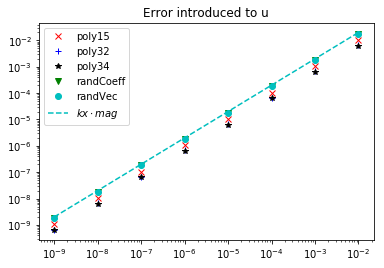

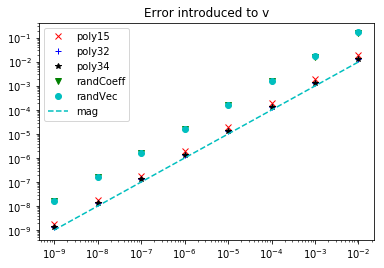

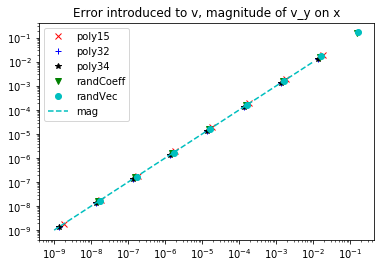

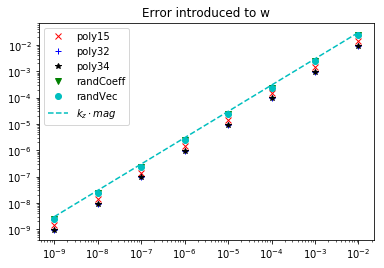

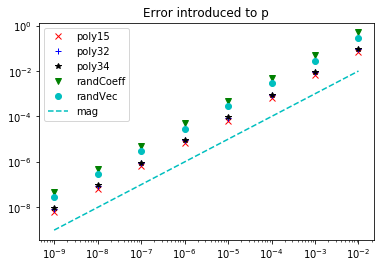

In [9]:
N = 35
y,DM = pseudo.chebdif(N,2)
D1 = np.ascontiguousarray(DM[:,:,0])
D2 = np.ascontiguousarray(DM[:,:,1])
yQuad = 1.-y**2
def linCost_lm(arr,kx,kz,flowDict):
    if kx == 0.: kxArr = np.array([0.]);xi = 0
    else : kxArr = np.array([0., kx, -2.*kx, -kx]);xi=1
    if kz == 0.: kzArr = np.array([0.]);zi=0
    else : kzArr = np.array([0., kz]);zi=1
    
    state = np.zeros((kxArr.size, kzArr.size, 4, N), dtype=np.complex)
    state[xi,zi].flat = arr
    
    linTerm = getLinTerm(state, kxArr, kzArr, flowDict)
    return qnorm(linTerm[xi,zi],N=N)

poly15 = (-y**2 - y**3 + y**8 + y**15); poly15 = (poly15/qnorm(poly15))
poly32= (y**2 +y**5 - y**11 + y**32); poly32 = poly32/qnorm(poly32)
poly34= (y**2 +y**7 - y**13 + y**34); poly34 = poly34/qnorm(poly34)
randCoeff = pseudo.chebcoll_vec(np.random.randn(N)).real; randCoeff = randCoeff/qnorm(randCoeff)
randVec = np.random.randn(N); randVec = randVec/qnorm(randVec)

# Calculate magnitude of first derivative of the errors
derFun = lambda arr: qnorm( -2.*y*arr + yQuad * (D1@arr))
der15 = derFun(poly15) 
der32 = derFun(poly32)
der34 = derFun(poly34)
derRC = derFun(randCoeff)
derRV = derFun(randVec)

magArr = 10**np.arange(-9., -1.)
flowDict = {'Re':400., 'U':y, 'Uy':np.ones(y.shape)} # PCoF flow

mode15 = np.zeros((4*N))
mode32= np.zeros((4*N))
mode34= np.zeros((4*N))
modeRV = np.zeros((4*N))
modeRC = np.zeros((4*N))

kx = 2.; kz = 3.

costArr = np.zeros((5,magArr.size))
for i in range(magArr.size):
    mode15[:N]  = magArr[i] * poly15
    costArr[0,i] = linCost_lm(mode15, kx, kz, flowDict)
    
    mode32[:N] = magArr[i] * poly32
    costArr[1,i] = linCost_lm(mode32, kx, kz, flowDict)
    
    mode34[:N] = magArr[i] * poly34
    costArr[2,i] = linCost_lm(mode34, kx, kz, flowDict)
    
    modeRC[:N] = magArr[i] * randCoeff
    costArr[3,i] = linCost_lm(modeRC, kx, kz, flowDict)
    
    modeRV[:N] = magArr[i] * randVec
    costArr[4,i] = linCost_lm(modeRV, kx, kz, flowDict)
    
plt.figure()
plt.title("Error introduced to u")
plt.loglog(magArr, costArr[0], 'rx', label='poly15')
plt.loglog(magArr, costArr[1], 'b+', label='poly32')
plt.loglog(magArr, costArr[2], 'k*', label='poly34')
plt.loglog(magArr, costArr[3], 'gv', label='randCoeff')
plt.loglog(magArr, costArr[4], 'co', label='randVec')
plt.loglog(magArr, kx*magArr, 'c--', label='$kx \cdot mag$')
plt.legend()
plt.show()



mode15 = np.zeros((4*N))
mode32= np.zeros((4*N))
mode34= np.zeros((4*N))
modeRV = np.zeros((4*N))
modeRC = np.zeros((4*N))

costArr = np.zeros((5,magArr.size))
for i in range(magArr.size):
    mode15[N:2*N]  = magArr[i] * poly15
    costArr[0,i] = linCost_lm(mode15, kx, kz, flowDict)
    
    mode32[N:2*N] = magArr[i] * poly32
    costArr[1,i] = linCost_lm(mode32, kx, kz, flowDict)
    
    mode34[N:2*N] = magArr[i] * poly34
    costArr[2,i] = linCost_lm(mode34, kx, kz, flowDict)
    
    modeRC[N:2*N] = magArr[i] * randCoeff
    costArr[3,i] = linCost_lm(modeRC, kx, kz, flowDict)
    
    modeRV[N:2*N] = magArr[i] * randVec
    costArr[4,i] = linCost_lm(modeRV, kx, kz, flowDict)
    
plt.figure()
plt.title("Error introduced to v")
plt.loglog(magArr, costArr[0], 'rx', label='poly15')
plt.loglog(magArr, costArr[1], 'b+', label='poly32')
plt.loglog(magArr, costArr[2], 'k*', label='poly34')
plt.loglog(magArr, costArr[3], 'gv', label='randCoeff')
plt.loglog(magArr, costArr[4], 'co', label='randVec')
plt.loglog(magArr, magArr, 'c--', label='mag')
plt.legend()
plt.show()

plt.figure()
plt.title("Error introduced to v, magnitude of v_y on x")
plt.loglog(der15*magArr, costArr[0], 'rx', label='poly15')
plt.loglog(der32*magArr, costArr[1], 'b+', label='poly32')
plt.loglog(der34*magArr, costArr[2], 'k*', label='poly34')
plt.loglog(derRC*magArr, costArr[3], 'gv', label='randCoeff')
plt.loglog(derRV*magArr, costArr[4], 'co', label='randVec')
plt.loglog(magArr, magArr, 'c--', label='mag')
plt.legend()
plt.show()





mode15 = np.zeros((4*N))
mode32= np.zeros((4*N))
mode34= np.zeros((4*N))
modeRV = np.zeros((4*N))
modeRC = np.zeros((4*N))
costArr = np.zeros((5,magArr.size))
for i in range(magArr.size):
    mode15[2*N:-N]  = magArr[i] * poly15
    costArr[0,i] = linCost_lm(mode15, kx, kz, flowDict)
    
    mode32[2*N:-N] = magArr[i] * poly32
    costArr[1,i] = linCost_lm(mode32, kx, kz, flowDict)
    
    mode34[2*N:-N] = magArr[i] * poly34
    costArr[2,i] = linCost_lm(mode34, kx, kz, flowDict)
    
    modeRC[2*N:-N] = magArr[i] * randCoeff
    costArr[3,i] = linCost_lm(modeRC, kx, kz, flowDict)
    
    modeRV[2*N:-N] = magArr[i] * randVec
    costArr[4,i] = linCost_lm(modeRV, kx, kz, flowDict)
    
plt.figure()
plt.title("Error introduced to w")
plt.loglog(magArr, costArr[0], 'rx', label='poly15')
plt.loglog(magArr, costArr[1], 'b+', label='poly32')
plt.loglog(magArr, costArr[2], 'k*', label='poly34')
plt.loglog(magArr, costArr[3], 'gv', label='randCoeff')
plt.loglog(magArr, costArr[4], 'co', label='randVec')
plt.loglog(magArr, kz*magArr, 'c--', label='$k_z \cdot mag$')
plt.legend()
plt.show()



mode15 = np.zeros((4*N))
mode32= np.zeros((4*N))
mode34= np.zeros((4*N))
modeRV = np.zeros((4*N))
modeRC = np.zeros((4*N))
costArr = np.zeros((5,magArr.size))
for i in range(magArr.size):
    mode15[-N:]  = magArr[i] * poly15
    costArr[0,i] = linCost_lm(mode15, kx, kz, flowDict)
    
    mode32[-N:] = magArr[i] * poly32
    costArr[1,i] = linCost_lm(mode32, kx, kz, flowDict)
    
    mode34[-N:] = magArr[i] * poly34
    costArr[2,i] = linCost_lm(mode34, kx, kz, flowDict)
    
    modeRC[-N:] = magArr[i] * randCoeff
    costArr[3,i] = linCost_lm(modeRC, kx, kz, flowDict)
    
    modeRV[-N:] = magArr[i] * randVec
    costArr[4,i] = linCost_lm(modeRV, kx, kz, flowDict)
    
plt.figure()
plt.title("Error introduced to p")
plt.loglog(magArr, costArr[0], 'rx', label='poly15')
plt.loglog(magArr, costArr[1], 'b+', label='poly32')
plt.loglog(magArr, costArr[2], 'k*', label='poly34')
plt.loglog(magArr, costArr[3], 'gv', label='randCoeff')
plt.loglog(magArr, costArr[4], 'co', label='randVec')
plt.loglog(magArr, magArr, 'c--', label='mag')
plt.legend()
plt.show()






# Non-linear terms

Do inverse Fourier transform (discrete, manual), then multiply in physical space, then transform back to Fourier space. 

__There is much optimization to be done here. I will get to this once things start to work properly.__

### Using numpy's FFT module

Numpy's FFT is undoubtedly faster than my custom implementation. The definition is a bit different though. 1-d FFT, for instance, is defined like so
$$ \hat{a}_{k, numpy} = \sum\limits_{m=0}^{n=1} a_m e^{-2\pi i \frac{m}{n} }. $$
I want a slightly different definition, illustrated below for 1d:
$$ \hat{a}_{k, custom} = \frac{1}{n} \sum\limits_{m=0}^{n=1} a(x=\frac{m}{n}L_x) e^{- i k \alpha x},$$
which can be simplified to
$$ \hat{a}_{k, custom} = \frac{1}{n} \sum\limits_{m=0}^{n=1} a_m e^{- 2\pi i \frac{m}{n}}.$$
So, 
$$ \hat{a}_{k,custom} = \frac{1}{n} \hat{a}_{k,numpy} $$

Similarly, numpy scales the sum in its ifft by $1/n$, while I don't want this scaling. Then
$$ a_{m,custom} = n a_{m,numpy} $$

In [10]:
#%load lib/eval.py
from lib.eval import getQuadTerm, NSECostFun
from lib.utils import _kxFun, _kzFun

## Testing getN0123()

In [11]:
# Initialize
alpha = 0.5; beta = 2.; L = 8; M = 8
N = 35
y = pseudo.chebdif(N,1)[0]
flowDict = {'Re':400., 'U':y, 'Uy':np.ones(y.shape),'y':y}

kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
state0= np.zeros((kxArr.size, kzArr.size, 4, N),dtype=np.complex)

### Zero vector

In [12]:
# Ensure zero state produces zero cost

def NLCost(state, kxArr, kzArr):
    return NSECostFun(state, kxArr, kzArr, flowDict, mode=2)
print("Cost for zero state:%f"%NLCost(state0, kxArr,kzArr) )

Cost for zero state:0.000000


F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:79: UserWarning: Calling chebdif 1...
  warn("Calling chebdif 1...")


### Low order polynomials



#### $N^0$
Set the coefficients
$\tilde{u}_{2,3} = 3y$, $\tilde{v}_{2,3} = y^2 -1$, and $\tilde{w}_{2,3} = iy^5$
Here, we use $(l,m)$ to reference modes. The actual wavenumber are $(k_x,k_z)=(l\alpha, m\beta) = (1,6)$. Note that the above functions must be multiplied with $(1-y^2)$ to get the velocities.

In the x-momentum equation for $(l,m) = (4,6)$.
$$ N^0_{4,6} = u u_x + v u' + w u_z = ik_xu u + vu' + ik_zwu \\
= i(1)(1-y^2)^2 (9y^2) + (1-y^2)(y^2-1)\{-2y(3y)+(1-y^2)(3)\} + i(6)(1-y^2)^2 (iy^5)(3y) \\
= T_1 + T_2 + T_3 \\
= i\{9y^2-18y^4+9y^6\}  + \{-3+15y^2-21y^4 +9y^6\} + \{- 18y^6 +36y^8 -18y^{10}\}  $$

In the x-momentum equation for $(l,m) = (0,0)$, due to interaction of modes (-2,-3) and (2,3). The mode (-2,-3) need not be specified, as it's implicit from real-valuedness as complex conjugate of (2,3). Two combinations contribute to this, one where derivatives are from (l,m) and another with derivatives from (-l,-m):
$$ N^0_{0,0} = \{u_{(-l,-m)} u_{x,(l,m)} + v_{(-l,-m)} u'_{(l,m)} + w_{(-l,-m)} u_{z,(l,m)} \}+
\{ u_{(l,m)} u_{x,(-l,-m)} + v_{(l,m)} u'_{(-l,-m)} + w_{(l,m)} u_{z,(-l,-m)} \}$$
Because $u$ and $v$ are real and $w$ is imaginary in our test case, 
$$ N^0_{0,0} = \{T_1 + T_2 - T_3\}  + \{-T_1 + T_2 - T_3 \} = 2(T_2 - T_3) $$

-------------------------

#### $N^1$
$$ N^1_{4,6} = u v_x + v v' + w v_z = ik_xu v + vv' + ik_zwv \\
   = i(1)(1-y^2)^2 (3y)(y^2-1) + (1-y^2)(y^2-1)\{-2y(y^2-1)+(1-y^2)(2y)\} + i(6)(1-y^2)^2 (iy^5)(y^2-1) \\
   = T_4 + T_5 + T_6 \\
   = \{ i(-3y + 9y^3 -9y^5 +3y^7)  \} + \{-4y + 12y^3 - 12y^5 + 4y^7 \} + \{6y^5 - 18y^7 + 18y^9 - 6y^{11} \} $$

As before, 
$$ N^1_{0,0} =\{ T_4 + T_5 - T_6\} + \{ -T_4 + T_5 - T_6 \} = 2(T_5 - T_6) $$


---------------------------
#### $N^2$

$$ N^2_{4,6} = u w_x + v w' + w w_z = ik_xu w + vw' + ik_zww \\
   = i(1)(1-y^2)^2 (3y)(iy^5) + (1-y^2)(y^2-1)\{-2y(iy^5)+(1-y^2)(5iy^4)\} + i(6)(1-y^2)^2 (iy^5)^2 \\
   = T_7 + T_8 + T_9 \\
   = \{ -3(y^6-2y^8+y^{10}) \} + \{ i(-5y^4+17y^6-19y^8 + 7y^{10} )\} + \{-6i( y^{10}-2y^{12}+y^{14} ) \} $$
   
$$ N^2_{0,0} =\{ T_7 + T_8 - T_9 \} + \{T_7 - T_8 + T_9 \} = 2T_7  $$
   


In [13]:
qnormLong = lambda arr: qnorm(arr,N=N)
state_23 = np.copy(state0) #Pump energy into (l,m)=(2,3)
# This should produce, in the NL term, energy in (l,m)=(2,6) and (l,m)=(0,0) only, the rest being zero.
poly1 = 3.*y
poly2 = y**2 - 1.
poly5 = 1.j*y**5 
state_23[2,3,0] = poly1
state_23[2,3,1] = poly2
state_23[2,3,2] = poly5
state_23[2,3,3] = np.random.randn(N)   # Pressure values should not affect non linear term

NL =  getQuadTerm(state_23,kxArr, kzArr,padding=False)

# N0
#=================================
N0_46 = NL[4,6,0]
N0_00 = NL[0,0,0]

T1 = 1.j*(9.*y**2 - 18.*y**4 + 9.*y**6)
T2 = (-3.+15.*y**2 - 21.*y**4 + 9.*y**6)
T3 = (- 18.*y**6 + 36.*y**8 - 18.*y**10) 
N0_46_calc =   T1 + T2 + T3
N0_00_calc =  2.*(T2-T3)

print("Did elements of N0_{4,6} match the analytical function?",np.allclose(N0_46.real, N0_46_calc.real) 
      and np.allclose(N0_46.imag,N0_46_calc.imag) )
print("Did elements of N0_{0,0} match the analytical function?",np.allclose(N0_00.imag, N0_00_calc.imag) 
      and np.allclose(N0_00.real,N0_00_calc.real) )

N0_tmp = np.copy(NL[:,:,0])
N0_tmp[4,6] = 0.
N0_tmp[0,0] = 0.

print("Norm of other elements of N0 should be close to zero: %.3g"% (qnormLong(N0_tmp)) )


# N1
#=================================
N1_46 = NL[4,6,1]
N1_00 = NL[0,0,1]

T4 =  1.j*(-3.*y + 9.*y**3 -9.*y**5 +3.*y**7)  
T5 = -4.*y + 12.*y**3 - 12.*y**5 + 4.*y**7 
T6 = 6.*y**5 - 18.*y**7 + 18.*y**9 - 6.*y**11

N1_46_calc =   T4 + T5 + T6
N1_00_calc =  2.*(T5-T6)

print()
print("Did elements of N1_{4,6} match the analytical function?",np.allclose(N1_46, N1_46_calc) )
print("Did elements of N1_{0,0} match the analytical function?",np.allclose(N1_00, N1_00_calc) )
print("Difference for (4,6) real:", qnormLong(N1_46.real-N1_46_calc.real))
print("Difference for (0,0) real:", qnormLong(N1_00.real-N1_00_calc.real))
print("Difference for (4,6) imag:", qnormLong(N1_46.imag-N1_46_calc.imag))
print("Difference for (0,0) imag:", qnormLong(N1_00.imag-N1_00_calc.imag))

N1_tmp = np.copy(NL[:,:,1])
N1_tmp[4,6] = 0.
N1_tmp[0,0] = 0.

print("Norm of other elements of N1 should be close to zero: %.3g"% (qnormLong(N1_tmp)) )

# N2
#===================================
N2_46 = NL[4,6,2]
N2_00 = NL[0,0,2]

T7 = -3.* (y**6 - 2.*y**8 + y**10)
T8 = 1.j* (-5.*y**4 + 17.*y**6 - 19.*y**8 + 7.*y**10 )
T9 = -6.j*(y**10 - 2.*y**12 + y**14 ) 
    
    
N2_46_calc =   T7 + T8 + T9
N2_00_calc =  2.*T7

print()
print("Did elements of N2_{4,6} match the analytical function?",np.allclose(N2_46, N2_46_calc) )
print("Did elements of N2_{0,0} match the analytical function?",np.allclose(N2_00, N2_00_calc) )
print("Difference for (4,6) real:", qnormLong(N2_46.real-N2_46_calc.real))
print("Difference for (0,0) real:", qnormLong(N2_00.real-N2_00_calc.real))
print("Difference for (4,6) imag:", qnormLong(N2_46.imag-N2_46_calc.imag))
print("Difference for (0,0) imag:", qnormLong(N2_00.imag-N2_00_calc.imag))

N2_tmp = np.copy(NL[:,:,2])
N2_tmp[4,6] = 0.
N2_tmp[0,0] = 0.

print("Norm of other elements of N2 should be close to zero: %.3g"% (qnormLong(N2_tmp)) )

print()
print("Norm of all elements of N3 should be zero: %.3g"%qnormLong(NL[:,:,3]))



Did elements of N0_{4,6} match the analytical function? True
Did elements of N0_{0,0} match the analytical function? True
Norm of other elements of N0 should be close to zero: 7.27e-16

Did elements of N1_{4,6} match the analytical function? True
Did elements of N1_{0,0} match the analytical function? True
Difference for (4,6) real: 1.9273695418364067e-15
Difference for (0,0) real: 3.84481594243656e-15
Difference for (4,6) imag: 4.682253505862429e-16
Difference for (0,0) imag: 0.0
Norm of other elements of N1 should be close to zero: 2.29e-16

Did elements of N2_{4,6} match the analytical function? True
Did elements of N2_{0,0} match the analytical function? True
Difference for (4,6) real: 8.903779772082685e-17
Difference for (0,0) real: 1.786093367619552e-16
Difference for (4,6) imag: 7.523615159173843e-16
Difference for (0,0) imag: 0.0
Norm of other elements of N2 should be close to zero: 1.54e-17

Norm of all elements of N3 should be zero: 0


F:\UoS\GCF\lib\eval.py:79: UserWarning: Calling chebdif 1...
  warn("Calling chebdif 1...")
F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:114: UserWarning: Calculating derivs in getQuadTerm.
  warn("Calculating derivs in getQuadTerm.")


## Wall-normal aliasing

The idea is simple: Use three error functions to introduce energy to some low wavenumber mode (worry about Fourier aliasing later). 
 
Use a polynomial of order 15, a polynomial of order 32, and a random vector. 

Plot cost versus energy of error introduced. 

F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:79: UserWarning: Calling chebdif 1...
  warn("Calling chebdif 1...")


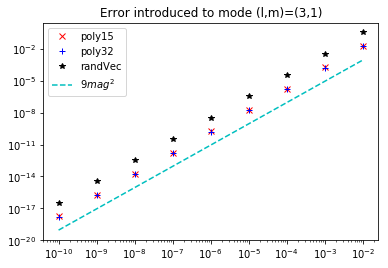

In [14]:
poly15 = -y + y**7 - y**11 + 2.*y**15
poly32 = -y + y**9 - y**16 + 2.*y**32
randVec = np.random.randn(N)

p15u = -y**6 + poly15; p15v = y**4 - 2.*poly15; p15w = y**8 + poly15
p32u = -y**6 + poly32; p32v = y**4 - 2.*poly32; p32w = y**8 + poly32
randu = -y**6 + randVec; randv = y**4 - 2.*randVec; randw = y**8 + randVec

Cu = 1. -2.5j; Cv = -2.+5.j; Cw = 3 + 1.j

p15u = Cu*p15u/qnorm(p15u); p15v = Cv*p15v/qnorm(p15v); p15w = Cw*p15w/qnorm(p15w); 
p32u = Cu*p32u/qnorm(p32u); p32v = Cv*p32v/qnorm(p32v); p32w = Cw*p32w/qnorm(p32w); 
randu = Cu*randu/qnorm(randu); randv = Cv*randv/qnorm(randv); randw = Cw*randw/qnorm(randw); 

p15 = np.concatenate((p15u, p15v, p15w, np.zeros(N))).reshape((4,N))
p32 = np.concatenate((p32u, p32v, p32w, np.zeros(N))).reshape((4,N))
randVec = np.concatenate((randu, randv, randw, np.zeros(N))).reshape((4,N))


alpha = 0.5; beta =2.; L = 8; M=8
kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)

state0 = np.zeros((2*L, M+1, 4, N), dtype=np.complex)
magArr = 10**np.arange(-10., -1.1)

state15 = np.zeros((state0.shape), dtype=np.complex)
state32 = np.zeros((state0.shape), dtype=np.complex)
stateRV = np.zeros((state0.shape), dtype=np.complex)

ix = 3; iz = 1 # Introduce energy to these modes
costArr = np.zeros((3,magArr.size))
for i in range(magArr.size):
    state15[ix,iz]  = magArr[i] * p15
    costArr[0,i] = NLCost(state15, kxArr, kzArr)
    
    state32[ix,iz]  = magArr[i] * p32
    costArr[1,i] = NLCost(state32, kxArr, kzArr)
    
    stateRV[ix,iz]  = magArr[i] * randVec
    costArr[2,i] = NLCost(stateRV, kxArr, kzArr)
    
    
plt.figure()
plt.title("Error introduced to mode (l,m)=(%d,%d)"%(ix,iz))
plt.loglog(magArr, costArr[0], 'rx', label='poly15')
plt.loglog(magArr, costArr[1], 'b+', label='poly32')
plt.loglog(magArr, costArr[2], 'k*', label='randVec')
plt.loglog(magArr, 9.*magArr**2, 'c--', label='9$mag^2$')
plt.legend()
plt.show()


__Looks okay to me.__

### Fourier aliasing

__Similar to above. Use the random vector at 3 or 4 different amplitudes, and then change the Fourier wavenumbers at which error is introduced.___

In [15]:
qnormLong_N = qnorm
randVec = np.random.randn(3*N) + 1.j*np.random.randn(3*N)
mode0 = np.zeros((4,N), dtype=np.complex)
mode0[:3] = randVec.reshape((3,N))/qnormLong(randVec)

alpha = 0.5; beta =2.; L = 12; M=7
kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)

magList = np.array([1.e-4,  5.e-2])
ixList = np.array([0, 4, 8, 11])

costArrNoPad = np.zeros((magList.size,2,ixList.size, kzArr.size))
costArrWithPad = np.zeros((magList.size,2,ixList.size, kzArr.size))
for iw in range(magList.size):
    mag = magList[iw]
    ind = 0
    for ix in ixList:
        print("ix:",ix)
        for iz in range(kzArr.size):
            print("iz:",iz)
            state = np.zeros((2*L, M+1, 4, N), dtype=np.complex)
            state[ix,iz] = mag * mode0
            NLNoPad = getQuadTerm(state, kxArr, kzArr, padding=False)
            NLWithPad = getQuadTerm(state, kxArr, kzArr, padding=True)
            
            costArrNoPad[iw,0, ind, iz] = qnormLong_N(NLNoPad[0,0], state.shape[-1])
            NLNoPad[0,0] = 0.
            costArrNoPad[iw,1, ind, iz] = qnormLong_N(NLNoPad, state.shape[-1])
            
            costArrWithPad[iw,0, ind, iz] = qnormLong_N(NLWithPad[0,0], state.shape[-1])
            NLWithPad[0,0] = 0.
            costArrWithPad[iw,1, ind, iz] = qnormLong_N(NLWithPad, state.shape[-1])
            
        ind+=1
    print("========================")
    print()

ix: 0
iz: 0
iz: 1
iz: 2
iz: 3


F:\UoS\GCF\lib\eval.py:79: UserWarning: Calling chebdif 1...
  warn("Calling chebdif 1...")
F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:114: UserWarning: Calculating derivs in getQuadTerm.
  warn("Calculating derivs in getQuadTerm.")


iz: 4
iz: 5
iz: 6
iz: 7
ix: 4
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7
ix: 8
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7
ix: 11
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7

ix: 0
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7
ix: 4
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7
ix: 8
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7
ix: 11
iz: 0
iz: 1
iz: 2
iz: 3
iz: 4
iz: 5
iz: 6
iz: 7



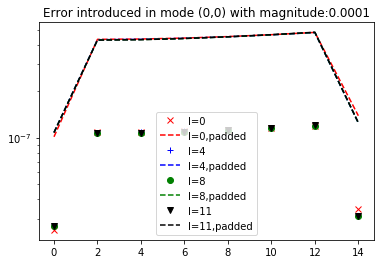

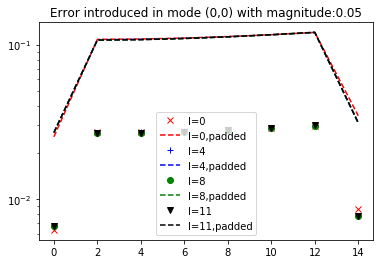

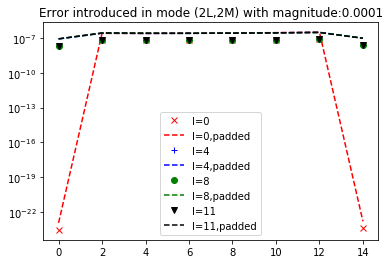

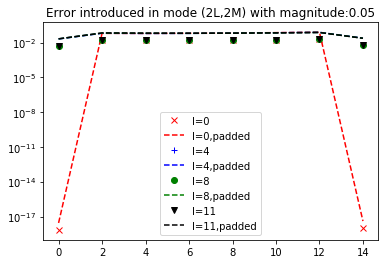

In [16]:
clrArr = ['r','b','g','k']
symArr = ['x','+', 'o','v']

for ind in range(magList.size):
    plt.figure()
    plt.title("Error introduced in mode (0,0) with magnitude:%g"%magList[ind])
    for ix in range(ixList.size):
        plt.semilogy(kzArr, costArrNoPad[ind,0,ix], '%s%s'%(clrArr[ix],symArr[ix]), label='l=%d'%ixList[ix])
        plt.semilogy(kzArr, costArrWithPad[ind,0,ix], '%s--'%(clrArr[ix]), label='l=%d,padded'%ixList[ix])
    plt.legend()
    plt.show()

for ind in range(magList.size):
    plt.figure()
    plt.title("Error introduced in mode (2L,2M) with magnitude:%g"%magList[ind])
    for ix in range(ixList.size):
        plt.semilogy(kzArr, costArrNoPad[ind,1,ix], '%s%s'%(clrArr[ix],symArr[ix]), label='l=%d'%ixList[ix])
        plt.semilogy(kzArr, costArrWithPad[ind,1,ix], '%s--'%(clrArr[ix]), label='l=%d,padded'%ixList[ix])
    plt.legend()
    plt.show()
    



Error in the (0,0) mode isn't dependent on padding, which is reasonable. There's one outlier though -  when error is introduced to $(0,M)$. This case shows larger error when not padded. I'm not completely sure if there is something physical here, or if it's an artefact of my custom implementation of FT. I will worry about this only if it doesn't go away when used with FFT. 


Error in the other modes (excluding (0,0)) changes when modes are padded. When padded, the error goes to zero for $k_z>6$, which should happen because the wavenumber $2k_z$ exceeds the ones captured in the NL term. When not padded, though, the error still remains. This should be an aliasing issue. The near-zero error for error introduced in $(0,0)$ is because I've already dropped this term from NL. 


## Timing NL cost with fft

In [ ]:
# Initialize
alpha = 0.5; beta = 2.; L = 8; M = 8
kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
state= 1.e-4*(  np.random.randn(kxArr.size, kzArr.size, 4, N) + 
               1.j*np.random.randn(kxArr.size, kzArr.size, 4, N)  )

print("Timing with L=%d, M=%d, N=35"%(L,M))
%timeit NLCost(state, kxArr, kzArr)
print(); print()

alpha = 0.5; beta = 2.; L = 16; M = 16
kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
state= 1.e-4*(  np.random.randn(kxArr.size, kzArr.size, 4, N) + 
               1.j*np.random.randn(kxArr.size, kzArr.size, 4, N)  )

print("Timing with L=%d, M=%d, N=35"%(L,M))
%timeit NLCost(state, kxArr, kzArr)
print(); print()

alpha = 0.5; beta = 2.; L = 24; M = 24
kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
state= 1.e-4*(  np.random.randn(kxArr.size, kzArr.size, 4, N) + 
               1.j*np.random.randn(kxArr.size, kzArr.size, 4, N)  )

print("Timing with L=%d, M=%d, N=35"%(L,M))
%timeit NLCost(state, kxArr, kzArr)
print(); print()


alpha = 0.5; beta = 2.; L = 32; M = 32
kxArr = _kxFun(alpha, L)
kzArr = _kzFun(beta, M)
state= 1.e-4*(  np.random.randn(kxArr.size, kzArr.size, 4, N) + 
               1.j*np.random.randn(kxArr.size, kzArr.size, 4, N)  )

print("Timing with L=%d, M=%d, N=35"%(L,M))
%timeit NLCost(state, kxArr, kzArr)
print(); print()

Timing with L=8, M=8, N=35


F:\UoS\GCF\lib\utils.py:102: UserWarning: Calling chebdif 3...
  warn("Calling chebdif 3...")
F:\UoS\GCF\lib\eval.py:79: UserWarning: Calling chebdif 1...
  warn("Calling chebdif 1...")


__Looks very promising. Let's put together the linear and non-linear parts and see where we are.__

# NSECostFun

In [ ]:
#%load lib/eval.py
from lib.eval import NSECostFun
from lib.utils import _kxFun, _kzFun

In [ ]:
# Initialize
alpha = 0.5; beta = 2.
Llist = np.array([8, 16, 24, 32, 56])
Mlist = Llist
N = 40
y, DM = pseudo.chebdif(N,2)
D1 = np.ascontiguousarray(DM[:,:,0])
D2 = np.ascontiguousarray(DM[:,:,1])
Re = 400.
U = y; Uy = np.ones(y.size)

flowDict = {'y':y, 'Re':Re, 'U':U, 'Uy':Uy, 'D1':D1, 'D2':D2, 'N':N}
for i in range(4,5):
    L = Llist[i]; M = Mlist[i]
    kxArr = _kxFun(alpha, L)
    kzArr = _kzFun(beta, M)
    state= 1.e-4*(  np.random.randn(kxArr.size, kzArr.size, 4, N) + 
                   1.j*np.random.randn(kxArr.size, kzArr.size, 4, N)  )

    print("Timing NSECostFun with L=%d, M=%d, N=35"%(L,M))
    %prun -s cumulative NSECostFun(state, kxArr, kzArr, flowDict, padding=False)
    #print("Just the linear array:")
    #%timeit getL0123(state, kxArr, kzArr, flowDict)
    print(); print()


In [106]:
from lib.utils import calcDerivatives
%prun calcDerivatives(state, kxArr, kzArr, flowDict=flowDict)

__Looks pretty good. 3s for $(56,56,35)$ isn't bad.__

## Up next
1. Iterate for laminar solution but now with more modes included
2. Check accuracy for, and iterate for, PCoF equilibria

This is not looking good. The iterations are taking too long even for a very low resolution case. I guess that is the cost I have to pay for matrix free methods. 

All hope is not lost though. There are still things that can be improved. 

I'll postpone comparison of optimization functions and my derivation of gradients for now. Focus on reducing evaluation time. 

0. __Final test for the evaluator with PCoF equilibria.__
1. __Profile the evaluator. See where things are taking long.__
2. __Look into GPU programming. If I can get the function evaluation time down by a factor of 10, then it's all good. Two packages seem promising:__
    * cuFFT for FFT.
    * gnumpy for matrix operations.
    
### Before doing all that, get the functions (and tests?) into a .py file

In [17]:
def tryChFlow(testField, yFun = None, disp=True, err_vel=0., err_p=0., zeta=1.):
    fName = 'data/eq1.h5'
    fName_pres = 'data/pres_eq1.h5'

    
    def getPhysFields(fName, fName_pres):
        alpha = 1.14; beta = 2.5; Re = 400.

        with h5py.File(fName,'r') as f:
            vel = np.array(f['data']['u'])
            x = np.array(f['geom']['x'])
            y = np.array(f['geom']['y'])
            z = np.array(f['geom']['z'])
        with h5py.File(fName_pres,'r') as f:
            p = np.array(f['data']['u'])
        return vel, p, alpha, beta, Re


    vel, p, alpha, beta, Re = getPhysFields(fName, fName_pres)


    # vel is shape (3, nx, ny, nz)
    # p is shape (1,(3/2)nx, ny, (3/2)nz); Padded with L/2 and M/2 modes
    if disp:
        print("Loaded physical fields from channel flow. Velocity fields and pressure field are of shape:")
        print(vel.shape, p.shape)

    # First, reshaping vel to (3,x,z,y) from (3, x,y,z); call this velT
    # Similarly for p
    nx = vel.shape[1]; ny = vel.shape[2]; nz = vel.shape[3]
    nxp = p.shape[1]; nyp = p.shape[2]; nzp = p.shape[3]
    y, DM = pseudo.chebdif(ny,2)
    D1 = np.ascontiguousarray(DM[:,:,0]) 
    D2 = np.ascontiguousarray(DM[:,:,1])

    # Test the later stuff a bit
    if testField :
        iField = 2
        vel[:] = 0.
        if yFun is None :
            yFun = y
        vel[iField] = (  yFun* (1.-y**2)   ).reshape((1,ny,1))
        p[:] = 0.
        if disp: print("Using testField for field %d using yFun:"%iField, yFun)

    velT = np.zeros((3,nx,nz,nyp), dtype=vel.dtype)
    pT = np.zeros((1,nxp, nzp, nyp), dtype=p.dtype)
    for k in range(nz):
        velT[:,:,k] = vel[:,:,:,k].reshape((3,nx,ny))
    for k in range(nzp):
        pT[:,:,k]  = p[:,:,:,k].reshape((1,nxp,nyp))
    if disp: print("Shapes of physical fields, velT and pT:", velT.shape, pT.shape )

    velT_BC = np.zeros(velT.shape)
    diffDict = {'y':y, 'D1':D1, 'D2':D2,'N':y.size}
    for iField in range(3):
        for ix in range(velT.shape[1]):
            for iz in range(velT.shape[2]):
                velT_BC[iField, ix,iz] = u2utilde(velT[iField, ix, iz], diffDict=diffDict)



    # Subtract U=y?
    #velT[0] -= y.reshape((1,1,y.size))

    # Now, convert physical fields to spectral fields. 
    # Remember, the physical fields are real valued.
    velSpec = np.fft.rfft2( velT_BC, axes=(1,2) )/(nx*nz)
    # Axis 1 is treated as usual, axis 2 is shortened to nz//2 + 1 because of real-valuedness
    # The division by (nx*nz) is to make numpy's fft scale to the one we need
    pSpecPadded = np.fft.rfft2( pT, axes=(1,2) )/(nx*nz)
    # Numpy orders Fourier wavenumbers for first FFT axis as 
    #       (0,1,2,..,L-1, +- L , -L+1, -L+2,..., -2, -1), L = nx//2 for even nx
    # The +- L is the Nyquist frequency and its coefficients are real. 
    # For the second FFT axis, the realvaluedness is applied to produce wavenumbers ordered
    #       (0,1,2,..., M), M = nz//2 for even nz

    # Drop pressure Fourier modes to make resolution consistent with velocity. 
    L = nx//2; M = nz//2
    pSpec = np.zeros((1, 2*L, M+1, ny), dtype=pSpecPadded.dtype)
    pSpec[0,:L , :M+1] = pSpecPadded[0,:L , :M+1]   
    pSpec[0,-L:, :M+1] = pSpecPadded[0,-L:, :M+1]
    # Now pSpec has shape consistent with velSpec
    
    # Add some random error to velocity and pressure fields:
    if err_vel > 0.:
        randVec = np.random.randn(*velSpec.shape) + 1.j*np.random.randn(*velSpec.shape)
        
        randVec = err_vel * randVec/np.sqrt(qnormLong_N(randVec,N)) * np.sqrt(qnormLong_N(velSpec,N))
        if disp: print("Adding noise of norm %.3g to spectral velocity field..."
                       %qnormLong_N(randVec,N))
        velSpec = velSpec + randVec
        if disp: print("velSpec has norm", qnormLong_N(velSpec,N))
    if err_p > 0.:
        randVec = np.random.randn(*pSpec.shape) + 1.j*np.random.randn(*pSpec.shape)
        randVec = err_p * randVec/np.sqrt(qnormLong_N(randVec,N)) * np.sqrt(qnormLong_N(pSpec,N))
        if disp: print("Adding noise of norm %.3g to spectral pressure field..."
                       %qnormLong_N(randVec,N))
        pSpec = pSpec + randVec
        if disp: print("pSpec has norm", qnormLong_N(pSpec,N))
    
    vel_p = np.concatenate((velSpec, pSpec), axis = 0)
    # We want to move the variable index (index that refers to variable; first index in this case)
    #       to be the third index, so that first and second index reference a Fourier mode
    vel_p_new = np.zeros((2*L, M+1, 4, ny), dtype=vel_p.dtype)
    for ind in range(4):
        vel_p_new[:,:,ind] = vel_p[ind]

    state_BC = vel_p_new
    
    if disp:
        print("Produced complex-valued state from channel flow solution. It's shape is")
        print(state_BC.shape)
        print("It's cost is:")
        
    kxArr = _kxFun(alpha, L)
    kzArr = _kzFun(beta, M)
    U = y; Uy = np.ones(y.size) 
    flowDict = {'N':N, 'y':y, 'Re':Re, 'U':U, 'Uy':Uy, 'D1':D1, 'D2':D2}
    if testField:
        state_BC[0,0,iField] -= yFun

    cost = NSECostFun(state_BC, kxArr, kzArr, flowDict, padding=True, fft=True,zeta=zeta)
    print(cost)
    return cost


0.0006432527610230975
0.2933471378191356
1.1651329087401272
2.600441777366554
4.661094091420543
7.343182136422502
10.587636516093761
14.340378571123637
18.73471889989063
24.21999406199566


No handles with labels found to put in legend.


30.480472416174045


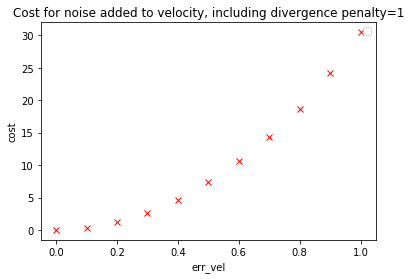

0.0006432527610230975
0.030432024428269887
0.12306594385442893
0.28008391116251824
0.5082109243293373
0.8177895354567003
1.2209489489841374
1.728145204762979
2.3478734141970614
3.1110018125080785


No handles with labels found to put in legend.


4.015625116277735


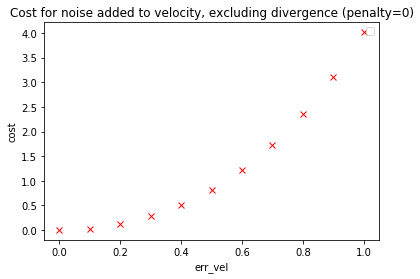

0.0006432527610230975
0.0008700922947411343
0.001570875869136798
0.002741525984723399
0.004339213475778411
0.00637695110570092
0.008865854303524549
0.011729103451361083
0.015295249274348492
0.019084848734691726


No handles with labels found to put in legend.


0.02356851799897038


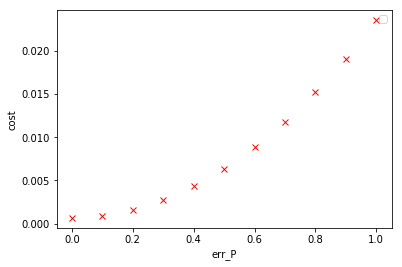

In [19]:
disp = False
yFun=None
useFit = False
errList = np.arange(0.,1.01,0.1)
#errVelList = np.arange(1.,10.,1.)

costList = []
zeta = 1.
for err in errList:
    costList.append( tryChFlow(False, yFun=yFun, disp=disp,err_vel=err, zeta=zeta) )
costArr = np.array(costList)
if useFit:
    fitFun = lambda arr: np.linalg.norm(costArr - arr[0] * errList**arr[1])
    coeff =  minimize(fitFun, [0., 4.]).x 
    plt.plot(errList, coeff[0]*errList**coeff[1], 'r-.', label='%.3g err^%.3g'%(coeff[0],coeff[1]))
    
plt.title("Cost for noise added to velocity, including divergence penalty=%.1g"%zeta)
plt.plot(errList, costList,'rx')
plt.legend()
plt.xlabel("err_vel"); plt.ylabel("cost")
plt.show()


costList = []
for err in errList:
    costList.append( tryChFlow(False, yFun=yFun, disp=disp,err_vel=err, zeta=0.) )
costArr = np.array(costList)
if useFit:
    fitFun = lambda arr: np.linalg.norm(costArr - arr[0] * errList**arr[1])
    coeff =  minimize(fitFun, [0., 4.]).x 
    plt.plot(errList, coeff[0]*errList**coeff[1], 'r-.', label='%.3g err^%.3g'%(coeff[0],coeff[1]))
    
plt.plot(errList, costList,'rx')
plt.title("Cost for noise added to velocity, excluding divergence (penalty=0)")
plt.legend()
plt.xlabel("err_vel"); plt.ylabel("cost")
plt.show()



errList = np.arange(0.,1.01,0.1)
#errVelList = np.arange(1.,10.,1.)
costList = []
for err in errList:
    costList.append( tryChFlow(False, yFun=yFun, disp=disp,err_p=err) )
costArr = np.array(costList)
if useFit :
    fitFun = lambda arr: np.linalg.norm(costArr - arr[0] * errList**arr[1])
    coeff =  minimize(fitFun, [0., 4.]).x 
    plt.plot(errList, coeff[0]*errList**coeff[1], 'r-.', label='%.3g err^%.3g'%(coeff[0],coeff[1]))
    
plt.plot(errList, costList,'rx')
plt.xlabel("err_P"); plt.ylabel("cost")
plt.legend()
plt.show()